### Objective of the analysis is to determine which factors contribute the most to engagement rate and follower growth for Facebook pages.

Disclaimer: The data describes the publicly available *organic* Facebook metrics of a popular Telecom in Myanmar, retrieved from Fanpage Karma. The analysis is done for education purpose only. Date range (Sep 9, 2022 - Dec 8, 2022)

To replicate the data collection process, 
- visit fanpagekarma.com,
- add a Facebook page of your choosing
- download CSV/Excel files from the selected metrics.

This is a practical study for the use case of competitor analysis to make inference about follower growth, content quality and engagement rate.

In [585]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveRegressor

In [586]:
df = pd.read_csv('facebook-stats(sep9-dec9).csv')

In [587]:
df.head()

,date,dotw,num of posts,engagement,picture post,video post,reaction per post,comment per post,share per post,abs follower growth,num of followers
0,9-Sep-22,Friday,1,0.12%,1,0,10870,1482.0,139,137,10558431
1,10-Sep-22,Saturday,1,0.01%,1,0,671,150.0,13,186,10558617
2,11-Sep-22,Sunday,0,0.00%,0,0,0,0.0,0,286,10558903
3,12-Sep-22,Monday,1,0.12%,0,1,11820,842.0,435,-217,10558686
4,13-Sep-22,Tuesday,1,0.13%,0,1,13078,782.0,261,181,10558867


Let's see if we have any null values

In [588]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 91 non-null     object 
 1   dotw                 91 non-null     object 
 2   num of posts         91 non-null     int64  
 3   engagement           91 non-null     object 
 4   picture post         91 non-null     int64  
 5   video post           91 non-null     int64  
 6   reaction per post    91 non-null     int64  
 7   comment per post     91 non-null     float64
 8   share per post       91 non-null     int64  
 9   abs follower growth  91 non-null     int64  
 10  num of followers     91 non-null     int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 7.9+ KB


Engagement column is in Object data types. Let's fix them by changing the type appropriately.

In [589]:
df['engagement'] = df['engagement'].str.replace('%', '')
df['engagement'] = df['engagement'].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 91 non-null     object 
 1   dotw                 91 non-null     object 
 2   num of posts         91 non-null     int64  
 3   engagement           91 non-null     float64
 4   picture post         91 non-null     int64  
 5   video post           91 non-null     int64  
 6   reaction per post    91 non-null     int64  
 7   comment per post     91 non-null     float64
 8   share per post       91 non-null     int64  
 9   abs follower growth  91 non-null     int64  
 10  num of followers     91 non-null     int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 7.9+ KB


From above data, 
1. we will add one more column to determine if a particular day is either a weekday or a weekend.
2. we will determine if a content has picture or video, deriving from columns 'picture post' and 'video post'

In [590]:
df['day-type'] = 'Weekday'
df['day-type'] = df['day-type'].mask(df.dotw == 'Saturday', 'Weekend').mask(df.dotw == 'Sunday', 'Weekend')
df['content-type'] = 'nil'
df['content-type'] = df['content-type'].mask(df['picture post'] == 1, 'picture')
df['content-type'] = df['content-type'].mask(df['video post'] == 1, 'video')

df = df.drop('picture post', axis = 1)
df = df.drop('video post', axis = 1)
print(df.head())

        date      dotw  num of posts  engagement  reaction per post  \
0   9-Sep-22    Friday             1        0.12              10870   
1  10-Sep-22  Saturday             1        0.01                671   
2  11-Sep-22    Sunday             0        0.00                  0   
3  12-Sep-22    Monday             1        0.12              11820   
4  13-Sep-22   Tuesday             1        0.13              13078   

   comment per post  share per post  abs follower growth  num of followers  \
0            1482.0             139                  137          10558431   
1             150.0              13                  186          10558617   
2               0.0               0                  286          10558903   
3             842.0             435                 -217          10558686   
4             782.0             261                  181          10558867   

  day-type content-type  
0  Weekday      picture  
1  Weekend      picture  
2  Weekend          nil  


## 1. Engagement

First, let's remove the outliers that may be lurking and skewing the engagement data.

We will then start with how the current content scheduling looks like.

<AxesSubplot:>

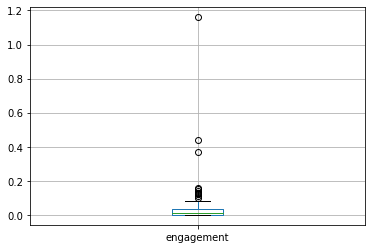

In [591]:
content_type_df = df
# Before we find the correlation, let us find and remove outliers first
content_type_df.boxplot(column="engagement")

<AxesSubplot:>

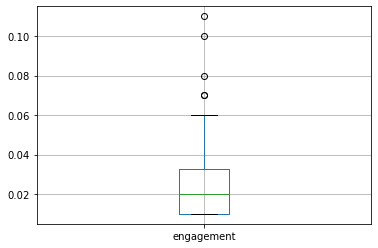

In [592]:
# That's a lot of strong outliers which are skewing the engagement-related data

q_low = content_type_df["engagement"].quantile(0.01)
q_hi  = content_type_df["engagement"].quantile(0.9)

# let's filter them out and create a new dataframe for analyzing engagement
engagement_df = content_type_df[(df["engagement"] < q_hi) & (content_type_df["engagement"] > q_low)]
engagement_df.boxplot(column="engagement")

### 1.1 How many times do we post on each day?

<AxesSubplot:xlabel='dotw'>

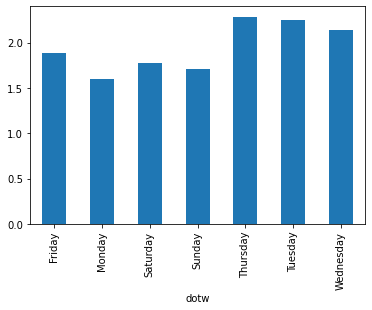

In [593]:
# let's see what our content scheduling looks like on each day of the week

dotw_publishing_df = engagement_df.groupby("dotw")["num of posts"].mean()
dotw_publishing_df.plot.bar()

### 1.2. Which days of the week drive most engagement?

<AxesSubplot:xlabel='dotw'>

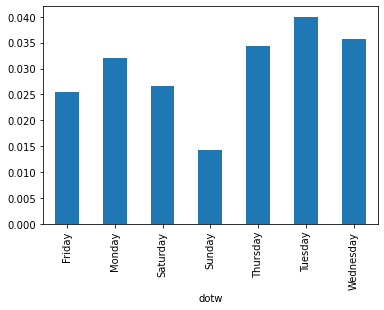

In [594]:
# We will make a bar chart to see if our engagement rate reflects the number of posts published each day of the week

dotw_engagement_df = engagement_df.groupby("dotw")["engagement"].mean()
dotw_engagement_df.plot.bar()

Here we notice that Tuesday brings us the highest engagement on average.

### 1.3. Which drives more engagement, weekday or weekend?

In [595]:
weekend = engagement_df[engagement_df["day-type"] == 'Weekend'].engagement.mean()
weekday = engagement_df[engagement_df["day-type"] == 'Weekday'].engagement.mean()

labels = ['Weekend', 'Weekday']
values = [weekend, weekday]

fig = px.pie(engagement_df, values=values, names=labels, 
             title='Average Engagement (%) on Weekend vs Weekdays', hole=0.5)
fig.show()

Weekdays on average are shown to deliver more engagement on average.

In [596]:
# We will use the dataframe that we have removed the outliers for more accuracy.

pic_content = engagement_df[engagement_df["content-type"] == 'picture']["engagement"].mean()
video_content = engagement_df[engagement_df["content-type"] == 'video']["engagement"].mean()

labels = ['picture', 'video']
values = [pic_content, video_content]

fig = px.pie(engagement_df, values=values, names=labels, 
             title='Average Engagement on Different Types of Content', hole=0.5)
fig.show()

Both pictures and videos have similar average engagement rate without outliers' influence.

### 1.4 Does number of shares received drive engagement?

Sometimes, a niche audience may share a content he or she likes, but that *doesn't* necessarily mean more engagement
1. if the topics you are publishing is NOT for general public
2. if the people are sharing with 'friend only' or 'only me' access.

We can infer some insights about our content's visibility based on correlation between shares and engagement.

In [597]:
figure = px.scatter(data_frame = engagement_df, x="share per post",
                    y="engagement", size="engagement", trendline="ols", 
                    title = "Relationship Between Share and Engagement Rate")
figure.show()

While there is a linear relation between share per post and engagement it generates, we can see its strongest outliers, after removing top 10%, are still skewing the trend. We will not remove any more outliers beyond top 10%. But we should be aware of their presence.

### 1.5 Does more followers mean more engagement?

In [598]:
figure = px.scatter(data_frame = engagement_df, 
                    x="num of followers",
                    y="engagement", 
                    size="engagement", 
                    trendline="ols", 
                    title = "Relationship Between Followers Count and Engagement Rate (%)",
                    width=700, height=500)
figure.show()

In the selected time period, we see that there is very little linear relation between the number of followers the page has and the engagement it receives. However, it should be noted that the small increase in engagement could still mean hundreds of potential conversion.

### 1.6 Can we hit target engagement by simply publishing more posts?

In [599]:
figure = px.scatter(data_frame = engagement_df, 
                    x="num of posts",
                    y="engagement", 
                    size="engagement", 
                    trendline="ols", 
                    title = "Relationship Between Followers Count and Engagement Rate (%)",
                    width=700, height=500)
figure.show()

Here we can see the almost flat linear relation that suggests that simply publishing more contents does not help us with higher engagement.

### 1.7 Correlations with Engagement Rate

In [600]:
correlation = engagement_df.corr()
print(correlation["engagement"].sort_values(ascending=False))

engagement             1.000000
reaction per post      0.977956
share per post         0.561253
comment per post       0.461995
abs follower growth    0.190717
num of followers       0.159694
num of posts           0.146821
Name: engagement, dtype: float64


Inference
1. A share-worthy post is a strong driver of engagement.
2. Number of posts we publish doesn't mean we get more engagement
3. Number of followers have nothing to do with getting a highly-engaging content

## 2. Which factors drive follower growth?

### 2.1 Does publishing more posts generate faster growth?

In [601]:
# To avoid confusion, we will duplicate a dataframe dedicated for this section.
follower_df = engagement_df

figure = px.scatter(data_frame = follower_df, 
                    x="num of posts",
                    y="abs follower growth", 
                    trendline="ols", 
                    title = "Relationship Between Number of Posts Published and Follower Growth",
                    width=700, height=500)
figure.show()

The linear relation is present, though little, between number of posts and engagement.

### 2.2 Does engaging content also help with follower growth?
Here, we know there are outliers in engagement data, So, let's use the dataframe that is already cleaned.

In [602]:
figure = px.scatter(data_frame = follower_df, 
                    x="engagement",
                    y="abs follower growth", 
                    trendline="ols", 
                    title = "Relationship Between Engagement Rate(%) and Followers Growth",
                    width=700, height=500)
figure.show()

Again, the engagement rate and follower growth has a small correlation, though very small.

### 2.3 Correlation with Follower Growth

In [603]:
correlation = follower_df.corr()
print(correlation["num of followers"].sort_values(ascending=False))

num of followers       1.000000
num of posts           0.371810
engagement             0.159694
reaction per post      0.131485
abs follower growth    0.029055
comment per post      -0.014564
share per post        -0.092272
Name: num of followers, dtype: float64


Inference
1. Consistent publishing of contents attributes to follower growth.
2. Creating engaging contents does not directly translate to growth.

It is to be concluded that Facebook algorithms rewards consistency over engagement, in which an outlier event may cause spiking follower growth, but will die down regular publishing.

# 3. Note for Predicting Results

Social Media is a highly volatile place when it comes to content marketing as creators can ride the trends and receive marvelous engagement. Outliers are frequent and paid ads often attribute to organic growth at times.

With the given dataset, we cannot build an adequate Machine Learning model to predict an organic result.

If you are working on your own social media page, you can include more valuable data such as reach, impressions and audience demographics which will lead to more accurate prediction model.

Below is a sample of how we can go about predicting the engagement rate **after** cleaning the outliers as much as possible.

In [604]:
mdl_building_df = df
mdl_building_df.head()

,date,dotw,num of posts,engagement,reaction per post,comment per post,share per post,abs follower growth,num of followers,day-type,content-type
0,9-Sep-22,Friday,1,0.12,10870,1482.0,139,137,10558431,Weekday,picture
1,10-Sep-22,Saturday,1,0.01,671,150.0,13,186,10558617,Weekend,picture
2,11-Sep-22,Sunday,0,0.00,0,0.0,0,286,10558903,Weekend,nil
3,12-Sep-22,Monday,1,0.12,11820,842.0,435,-217,10558686,Weekday,video
4,13-Sep-22,Tuesday,1,0.13,13078,782.0,261,181,10558867,Weekday,video


To train the dataset, let's change the descriptive values to numerical.

In [605]:
mdl_building_df['dotw'] = mdl_building_df['dotw'].mask(mdl_building_df['dotw'] == 'Monday', 1
                                                      ).mask(mdl_building_df['dotw'] == 'Tuesday', 2
                                                            ).mask(mdl_building_df['dotw'] == 'Wednesday', 3
                                                                  ).mask(mdl_building_df['dotw'] == 'Thursday', 4
                                                                        ).mask(mdl_building_df['dotw'] == 'Friday', 5
                                                                              ).mask(mdl_building_df['dotw'] == 'Saturday', 6
                                                                                    ).mask(mdl_building_df['dotw'] == 'Sunday',7)

mdl_building_df['day-type'] = mdl_building_df['day-type'].mask(mdl_building_df['day-type']=='Weekend',1).mask(mdl_building_df['day-type']=='Weekday',0)
mdl_building_df['content-type'] = mdl_building_df['content-type'].mask(mdl_building_df['content-type']=='picture',1).mask(mdl_building_df['content-type']=='video',0)

In [606]:
#mdl_building_df = mdl_building_df.drop(['date','reaction per post', 'engagement', 'share per post', 'comment per post','num of followers','a'], axis = 1)
mdl_building_df.head()

,date,dotw,num of posts,engagement,reaction per post,comment per post,share per post,abs follower growth,num of followers,day-type,content-type
0,9-Sep-22,5,1,0.12,10870,1482.0,139,137,10558431,0,1
1,10-Sep-22,6,1,0.01,671,150.0,13,186,10558617,1,1
2,11-Sep-22,7,0,0.00,0,0.0,0,286,10558903,1,nil
3,12-Sep-22,1,1,0.12,11820,842.0,435,-217,10558686,0,0
4,13-Sep-22,2,1,0.13,13078,782.0,261,181,10558867,0,0


In [607]:
mdl_building_df = mdl_building_df[mdl_building_df['content-type']!='nil']
mdl_building_df['day-type'] = mdl_building_df['day-type'].astype('float64')
mdl_building_df['content-type'] = mdl_building_df['content-type'].astype('float64')
mdl_building_df.head()

,date,dotw,num of posts,engagement,reaction per post,comment per post,share per post,abs follower growth,num of followers,day-type,content-type
0,9-Sep-22,5,1,0.12,10870,1482.0,139,137,10558431,0.0,1.0
1,10-Sep-22,6,1,0.01,671,150.0,13,186,10558617,1.0,1.0
3,12-Sep-22,1,1,0.12,11820,842.0,435,-217,10558686,0.0,0.0
4,13-Sep-22,2,1,0.13,13078,782.0,261,181,10558867,0.0,0.0
6,15-Sep-22,4,1,0.01,1321,178.0,21,-869,10557466,0.0,0.0


In [608]:
x = np.array(mdl_building_df[['share per post',
                              'num of posts', 
                              'num of followers', 
                              'day-type',
                              'content-type']])
y = np.array(mdl_building_df['engagement'])
xtrain, xtest, ytrain, ytest = train_test_split(x, y, 
                                                test_size=0.1, 
                                                random_state=30)

In [609]:
model = PassiveAggressiveRegressor()
model.fit(xtrain, ytrain)
model.score(xtest, ytest)

-0.011501505699680559

Note the score in negative. Rely on the model only if it is in decent 75-80% or 0.75 and above.

In [610]:
features = np.array([[100, 1, 10559000, 0, 1,]])
model.predict(features)

array([0.09980108])